# Random Forest and GBDT on Amzon Fine Food Review

# Amazon Fine Food Review is about the reviews of customers on the food.

Number of columns: 10
Number of rows: 568454
Number of reviews: 568454
Number of products: 74258
Number of users: 256059

# Attribute information:
 
1) Id: Number of rows

2) ProductId: Unique ID of product 

3) UserId: User identification number

4) ProfileName: User name

5) HelpfulnessNumerator: Number of user found the review helpful

6) HelpfulnessDenominator: Number of user who found the review helpful or not

7) Score: Rating given to the product

8) Time: Timestamp at the time of review posted

9) Summary: Short version of text review

10) Text: Detailed text review

# Objective:

We need to find if the review is positive (1) or negative (0).

We are provided with the score from 1 to 5. Let's assume score 1 & 2 are negative and score 4 & 5 are positive. We are ignoring 3 as it can be considered as neutral.

# Loading Dataset

In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline

from time import time

# warnings library is to ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing dataset

df = pd.read_csv('Reviews.csv')

# Displaying first 5 rows
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

# Data Information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [4]:
print('Number of columns:' + ' ' + str(len(df.columns)))
print('Number of rows:' + ' ' + str(df['Id'].nunique()))
print('Number of reviews:' + ' ' + str(df['Id'].nunique()))
print('Number of products:' + ' ' + str(df['ProductId'].nunique()))
print('Number of users:' + ' ' + str(df['UserId'].nunique()))

Number of columns: 10
Number of rows: 568454
Number of reviews: 568454
Number of products: 74258
Number of users: 256059


# Assign Polarity

Let us assign positive (1) to the score 4 and 5

Let us assign negative (0) to the score 1 and 2

Let us ignore score having 3

In [5]:
# Let us first create a new dataset which doesn't have score 3 and it's respective rows.

print('Number of rows before removing score 3:' + ' ' + str(df['Id'].nunique()))

df_score = df[df['Score'] != 3]

print('Number of rows after removing score 3:' + ' ' + str(df_score['Id'].nunique()))

Number of rows before removing score 3: 568454
Number of rows after removing score 3: 525814


In [6]:
# Defining a function to assign polarity.

def scr(sc):
    if sc > 3:
        return 1
    return 0

In [7]:
# Calling function to assign polarity using .apply()
df_score['Score'] = df_score['Score'].apply(scr)

print("Number of positive (1) and negative (0) reviews")

df_score['Score'].value_counts()

Number of positive (1) and negative (0) reviews


1    443777
0     82037
Name: Score, dtype: int64

# Exploratory Data Analysis

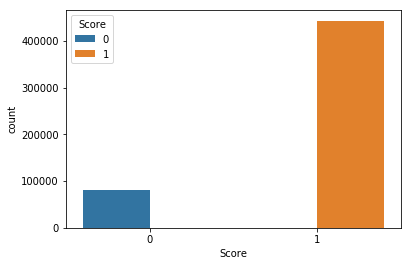

In [8]:
sns.countplot(df_score['Score'], hue = df_score['Score'])

# Observation:

As we can see, number of negative reviews are closer to 10k while positive review is more than 400k.

Ratio of negative and positive review can be assumed to be ~ 1:4.

Also, we can conclude that ~90% of the reviews are positive.

# Data Cleaning:

We have performed few techniques to clean the text and summary data

1) Null values removed

2) Duplicates removed

3) URL links removed

4) HTML tags removed

5) Stopwords removed

6) Stem words obtained

7) Converted from short form word to long form word

We have already performed above data clearning technique and saved.

Importing the clean data.

In [9]:
df_clean = pd.read_csv('Amazon_Final_time.csv')

df_clean = df_clean.dropna()

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364149 entries, 150523 to 327600
Data columns (total 12 columns):
Id                        364149 non-null int64
ProductId                 364149 non-null object
UserId                    364149 non-null object
ProfileName               364149 non-null object
HelpfulnessNumerator      364149 non-null int64
HelpfulnessDenominator    364149 non-null int64
Score                     364149 non-null int64
Time                      364149 non-null int64
Summary                   364149 non-null object
Text                      364149 non-null object
Clean_Text                364149 non-null object
Clean_Summary             364149 non-null object
dtypes: int64(5), object(7)
memory usage: 36.1+ MB


In [10]:
percentage_red = np.round((df_clean.shape[0]/df.shape[0]),5)*100
print("Data percentage reduced to ", percentage_red)

Data percentage reduced to  64.05999999999999


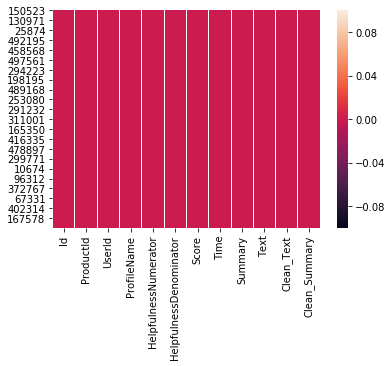

In [11]:
sns.heatmap(df_clean.isnull())

# Observation:
    
There are no null values now. We are good to go to proceed with vectorization

# 100k dataframe

Picking up random 100k samples from the dataset

In [221]:
df_100k = df_clean.sample(n = 100000)

print("Shape of sample dataframe is ", df_100k.shape)
print("Total number of rows: ", df_100k.shape[0])
print("Total number of columns: ", df_100k.shape[1])

Shape of sample dataframe is  (100000, 12)
Total number of rows:  100000
Total number of columns:  12


# Time Series Split

Since the dataset is based on time series, we need to sort based on time in an ascending order

In [222]:
df_sort_100k = df_100k.sort_values('Time', ascending = True)

In [223]:
x_100k = df_sort_100k['Clean_Text']
y_100k = df_sort_100k['Score']

print(x_100k.shape)
print(y_100k.shape)

(100000,)
(100000,)


# Defining functions 'rfi' and 'md' to find best hyperparameters- n_estimators and maximum depth.

In [238]:
# Defining functions 'rfi' to find best hyperparameters- n_estimators and maximum depth.

# Import libraries

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

max_dep =  [2, 3, 5, 8, 10]
n_est = [5, 10, 50, 100, 500]

def rfi(cl, tr_x, cv_x, tr_y, cv_y, n_est, max_depth): 
    
    # To pick the maximum depth and estimator corresponding to maximum AUC score
    ma_cv = 0
    max_dep_value_cv = 0
    n_estimator_cv = 0
    
    # To pick the maximum depth and estimator corresponding to maximum AUC score
    ma_tr = 0
    max_dep_value_tr = 0
    n_estimator_tr = 0
    
    # Empty list to store AUC scores of CV and train set
    auc_cv = []
    auc_tr = []
    
    # Empty list to store maximum depth and estimators to create dataframe
    c_max = []
    c_est = []
    
    for m in n_est:
        
        for i in max_depth:

            # Classifier
            rf = cl(n_estimators = m, max_depth = i, random_state = 0)
            rf = rf.fit(tr_x, tr_y)
        
            # AUC score for CV data
            rf_pred_cv = rf.predict_proba(cv_x)[:,-1]
            rf_sc_cv = roc_auc_score(cv_y, rf_pred_cv)
            auc_cv.append(rf_sc_cv)
        
            # AUC score for train data
            rf_pred_tr = rf.predict_proba(tr_x)[:,-1]
            rf_sc_tr = roc_auc_score(tr_y, rf_pred_tr)
            auc_tr.append(rf_sc_tr)
            
            # To pick the maximum depth and estimator corresponding to maximum AUC score
            if ma_cv < rf_sc_cv:
                ma_cv = rf_sc_cv
                max_dep_value_cv = i
                n_estimator_cv = m
            
            # To pick the maximum depth and estimator corresponding to maximum AUC score
            if ma_tr < rf_sc_tr:
                ma_tr = rf_sc_tr
                max_dep_value_tr = i
                n_estimator_tr = m
                
    
    # Creating a dataframe which later can be used for 3d plot and/or heatmap to visualize scores.
    
            c_max.append(i)
            c_est.append(m)
            
    d1 = {'Estimators' : c_est, 'Maximum depth' : c_max, 'CV AUC' : auc_cv, 'Train AUC' : auc_tr}
    d_final = pd.DataFrame(data = d1, columns = ['Estimators', 'Maximum depth', 'CV AUC', 'Train AUC'])
        
    # max_depth and auc score of CV
    print('*'*30)
    print("Optimal values of CV")
    print('*'*30, '\n')
    print("Optimal n_estimators of CV:", n_estimator_cv)
    print("Optimal maximum depth of CV:", max_dep_value_cv)
    print("Corresponding AUC score of CV:", ma_cv, '\n')
    
    # max_depth and auc score of train
    print('*'*30)
    print("Optimal values of train")
    print('*'*30, '\n')
    print("Optimal n_estimators of train:", n_estimator_tr)
    print("Optimal maximum depth of train:", max_dep_value_tr)
    print("Corresponding AUC score of train:", ma_tr)
    
    return auc_cv, auc_tr, d_final

# Defining a function 'heat' to visual with heatmap

Referred from: https://seaborn.pydata.org/generated/seaborn.heatmap.html

In [225]:
# Defining a function 'heat' to visual with heatmap

def heat(d, n_est, max_depth, score):
    
    d_pivot = d.pivot(n_est, max_depth, score)
    d_heat = sns.heatmap(d_pivot, annot = True, linewidths = 2)
    plt.title("\nHeatmap for AUC score, maximum depth, and estimator\n")
    
    return d_heat

# Defining a function 'd_plot' for 3-d plot visual

Referred from https://plot.ly/python/3d-axes/

In [226]:
# Defining a function 'd_plot' for 3-d plot visual

# import libraries

import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

def d_plot(max_depth, n_est, score, label):
    
    axis = go.Scatter3d(x = max_depth, y = n_est, z = score, name = label)
    axis_data = [axis]

    layout = go.Layout(scene = dict( xaxis = dict(title = 'Estimator'),
                                     yaxis = dict(title = 'Max depth'),
                                     zaxis = dict(title = 'AUC score'),))

    fig = go.Figure(data = axis_data, layout = layout)
    offline.iplot(fig, filename = '3d-scatter-colorscale')

# Defining a function to check performance model with ROC AUC curve

In [227]:
# Defining a function to check performance model with ROC AUC curve
# Import libraries

from sklearn.metrics import roc_curve, auc
from sklearn import metrics

def mod_per(cl, tr_x, te_x, tr_y, te_y, n_est, max_dep):
    
    rf = cl(n_estimators = n_est, max_depth = max_dep, random_state = 0)
    rf = rf.fit(tr_x, tr_y)
    
    pred_p = rf.predict_proba(te_x)[:,-1]
    fpr, tpr, threshold = metrics.roc_curve(te_y, pred_p)
    roc_auc_scr = auc(fpr, tpr)
    
    plt.figure(figsize = (6,4))
    
    plt.plot(fpr, tpr, color = 'b', label = roc_auc_scr)
    plt.plot([0, 1], [0, 1],'r--')
    
    plt.legend()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("ROC AUC curve")
 

# Defining a function to predict test data and get the metrics

In [228]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix

def test_metric(cl, train_x, test_x, train_y, test_y, n_est, max_dep):
    
    # Classifier
    rf = cl(n_estimators = n_est, max_depth = max_dep, random_state = 0)
    rf = rf.fit(train_x, train_y)
    
    # Prediction
    pred = rf.predict(test_x)
    
    # predict_proba_ for roc_auc_score
    pred_pro = rf.predict_proba(test_x)[:,-1]
    
    # Getting metrics
    print("Metric scores of test data")
    print('*'*25, '\n')
    
    roc_auc = np.round(roc_auc_score(test_y, pred_pro),3)
    print("ROC AUC score: ", roc_auc, '\n')
    print('*'*25, '\n')
    
    precision = np.round(precision_score(test_y, pred),3)
    print("Precision score: ", precision, '\n')
    print('*'*25, '\n')
    ow_
    f1 = np.round(f1_score(test_y, pred),3)
    print("F1 score: ", f1, '\n')
    print('*'*25, '\n')
    
    recall = np.round(recall_score(test_y, pred),3)
    print("Recall score: ", recall, '\n')
    print('*'*25, '\n')
    
    class_report = classification_report(test_y, pred)
    print("Classification Report:", '\n')
    print(class_report, '\n')
    print('*'*25, '\n')
    
    print("Confusion matrix table:", '\n')
    skplt.metrics.plot_confusion_matrix(test_y, pred)
    
    return roc_auc, precision, f1, recall, rf

# Split into train, cv and test set

In [365]:
# Import train_test_split library
from sklearn.model_selection import train_test_split

# Split into train and test set
x_train, x_test, y_train, y_test = train_test_split(x_100k, y_100k, random_state = 0, test_size = 0.2, shuffle = False)

# Split into train and cv set
x_tr, x_cv, y_tr, y_cv = train_test_split(x_train, y_train, random_state = 0, test_size = 0.25, shuffle = False)

In [366]:
print("Shape of x_tr: ", x_tr.shape)
print("Shape of x_cv: ", x_cv.shape)
print("Shape of x_test: ", x_test.shape)
print("Shape of y_train: ", y_tr.shape)
print("Shape of y_cv: ", y_cv.shape)
print("Shape of y_test: ", y_test.shape)

Shape of x_tr:  (60000,)
Shape of x_cv:  (20000,)
Shape of x_test:  (20000,)
Shape of y_train:  (60000,)
Shape of y_cv:  (20000,)
Shape of y_test:  (20000,)


# Random Forest- Bag of Words

In [367]:
# Import CountVectorizer library
from sklearn.feature_extraction.text import CountVectorizer

# Create an instance
# Bi-gram
cv = CountVectorizer(ngram_range = (1,2))

# Fit and transform train data
x_tr_f = cv.fit_transform(x_tr)

# Transform cv data
x_cv_f = cv.transform(x_cv)

# Transform test data
x_test_f = cv.transform(x_test)

# Normalization

Normalization is a feature scaling technique which transforms all the data variables to the same scale or in same range i.e 0.0 to 0.1

In [368]:
# Import normalize library
from sklearn.preprocessing import normalize

# Normalize train data
x_tr_n = normalize(x_tr_f)

# Normalize train data
x_cv_n = normalize(x_cv_f)

# Normalize test data
x_test_n = normalize(x_test_f)

In [369]:
print("Shape of x_tr_n: ", x_tr_n.shape)
print("Shape of x_cv_n: ", x_cv_n.shape)
print("Shape of x_test_n: ", x_test_n.shape)
print("Shape of y_tr: ", y_tr.shape)
print("Shape of y_cv: ", y_cv.shape)
print("Shape of y_test: ", y_test.shape)

Shape of x_tr_n:  (60000, 890865)
Shape of x_cv_n:  (20000, 890865)
Shape of x_test_n:  (20000, 890865)
Shape of y_tr:  (60000,)
Shape of y_cv:  (20000,)
Shape of y_test:  (20000,)


# Calling 'rfi' function to find optimal n_estimators and maximum depth.

In [370]:
# Calling 'rfi' function to find optimal n_estimators and maximum depth.

r_sc_b, r_st_b, r_d_b = rfi(RandomForestClassifier, x_tr_n, x_cv_n, y_tr, y_cv, n_est, max_dep)

******************************
Optimal values of CV
****************************** 

Optimal n_estimators of CV: 500
Optimal maximum depth of CV: 8
Corresponding AUC score of CV: 0.8956098178113878 

******************************
Optimal values of train
****************************** 

Optimal n_estimators of train: 500
Optimal maximum depth of train: 10
Corresponding AUC score of train: 0.9280711071885667


In [372]:
r_e_b = 500
r_m_b = 8

# Calling 'heat' function to visualize CV AUC score with heatmap.

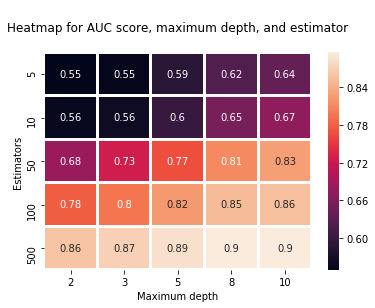

In [373]:
# Calling 'heat' function to visualize CV AUC score with heatmap.

heat(r_d_b, 'Estimators', 'Maximum depth', 'CV AUC')

# Calling 'heat' function to visualize train AUC score with heatmap.

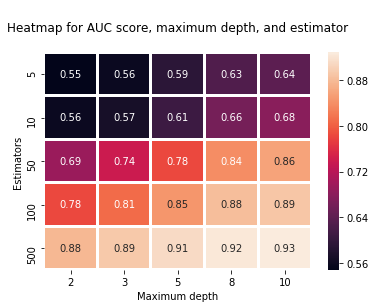

In [374]:
# Calling 'heat' function to visualize train AUC score with heatmap.

heat(r_d_b, 'Estimators', 'Maximum depth', 'Train AUC')

# Observation:

For CV, n_estimators is 500 and maximum depth is 8 and AUC score is 89% 

For train, n_estimators is 500 and maximum depth is 10 and AUC score is 93%

Optimal n_estimators: 500

Optimal maximum depth: 8

# Calling 'mod_per' function to check the performance model with ROC curve on CV

n_estimators: 500

maximum depth: 8

 
 Model performance with estimators 500 and maximum depth 8 



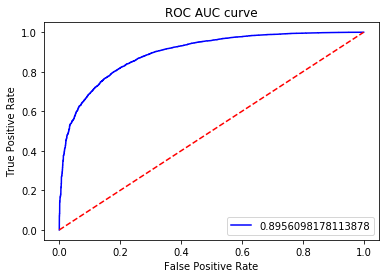

In [375]:
# Calling 'mod_per' function to check the performance model with ROC curve on CV.
# n_estimators = 500
# Maximum depth = 8

print(" \n Model performance with estimators", r_e_b,"and maximum depth", r_m_b,'\n')

mod_per(RandomForestClassifier, x_tr_n, x_cv_n, y_tr, y_cv, r_e_b, r_m_b)

# Observation:
    
We can see that the model probability to separate positive and negative review is 89%

# Calling 'test_metric' function to predict test data and get metrics

n_estimators: 500

Maximum depth: 8

Metric scores of test data
************************* 

ROC AUC score:  0.895 

************************* 

Precision score:  0.825 

************************* 

F1 score:  0.904 

************************* 

Recall score:  1.0 

************************* 

Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3493
           1       0.83      1.00      0.90     16507

   micro avg       0.83      0.83      0.83     20000
   macro avg       0.41      0.50      0.45     20000
weighted avg       0.68      0.83      0.75     20000
 

************************* 

Confusion matrix table: 



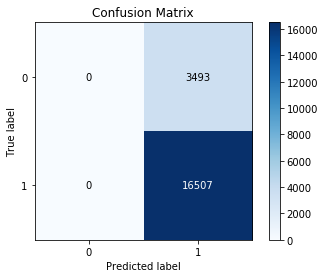

In [376]:
# Calling 'test_metric' function to predict test data and get metrics
# n_estimators: 500
# Maximum depth: 8

rab, pb, fb, reb, bow_te = test_metric(RandomForestClassifier, x_tr_n, x_test_n, y_tr, y_test, r_e_b, r_m_b)

# Calling 'mod_per' to check model performance with ROC AUC curve on test data

n_estimators: 500

Maximum depth: 8

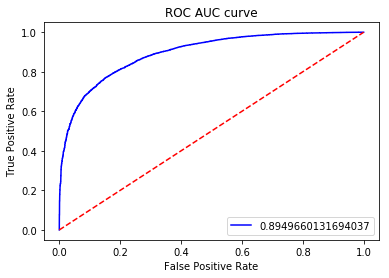

In [377]:
# Calling 'mod_per' to check model performance with ROC AUC curve on test data
# n_estimators: 500
# Maximum depth: 8

mod_per(RandomForestClassifier, x_tr_n, x_test_n, y_tr, y_test, r_e_b, r_m_b)

# Observation

Model probabillity of separating positive and negative review is 89%

# Random Forest- TF-IDF: Term Frequency Inverse Document Frequency

In [379]:
# Import TfidfVectorizer library
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance
tf = TfidfVectorizer()

# Fit and transform train data
x_tr_tf = tf.fit_transform(x_tr)

# Transform cv data
x_cv_tf = tf.transform(x_cv)

# Transform test data
x_test_tf = tf.transform(x_test)

# Normalization

In [380]:
# Import normalize library
from sklearn.preprocessing import normalize

# Normalize train data
x_tr_tf_n = normalize(x_tr_tf)

# Normalize cv data
x_cv_tf_n = normalize(x_cv_tf)

# Normalize test data
x_test_tf_n = normalize(x_test_tf)

# Calling 'rfi' function to find n_estimators and maximum depth.

In [381]:
# Calling 'rfi' function to find n_estimators and maximum depth.

r_sc_tf, r_st_tf, r_d_tf = rfi(RandomForestClassifier, x_tr_tf_n, x_cv_tf_n, y_tr, y_cv, n_est, max_dep)

******************************
Optimal values of CV
****************************** 

Optimal n_estimators of CV: 500
Optimal maximum depth of CV: 10
Corresponding AUC score of CV: 0.8951296530317703 

******************************
Optimal values of train
****************************** 

Optimal n_estimators of train: 500
Optimal maximum depth of train: 10
Corresponding AUC score of train: 0.921900735647646


# Calling 'heat' function to visualize CV AUC with heatmap

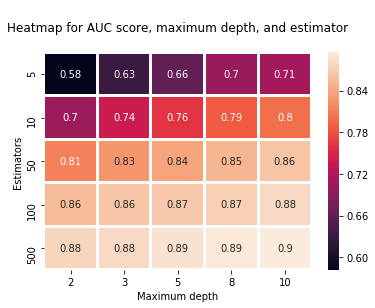

In [382]:
# Calling 'heat' function to visualize CV AUC with heatmap

heat(r_d_tf, 'Estimators', 'Maximum depth', 'CV AUC')

# Calling 'heat' function to visualize train AUC with heatmap.

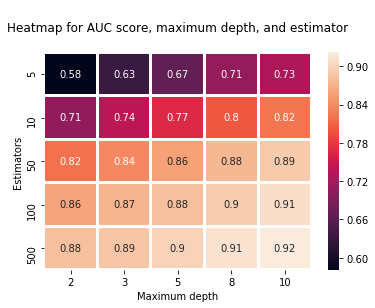

In [383]:
# Calling 'heat' function to visualize train AUC with heatmap

heat(r_d_tf, 'Estimators', 'Maximum depth', 'Train AUC')

# Observation:

For CV, n_estimators is 500 and maximum depth is 10 and AUC score is 89% 

For train, n_estimators is 500 and maximum depth is 10 and AUC score is 92%

Optimal n_estimators: 500

Optimal maximum depth: 10

In [384]:
r_e_tf = 500
r_m_tf = 10

# Calling 'mod_per' function to check the model performance with ROC AUC score on CV data

n_estimators: 500

Maximum depth: 10

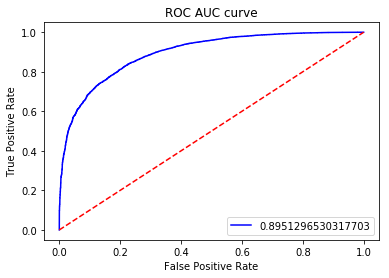

In [386]:
# Calling 'mod_per' function to check the model performance with ROC AUC score on CV data
# n_estimators: 500
# Maximum depth: 10

mod_per(RandomForestClassifier, x_tr_tf_n, x_cv_tf_n, y_tr, y_cv, r_e_tf, r_m_tf)

# Observation:

Probability of model to separate positive and negative review is 89%

# Calling 'test_metric' function to predict test data and get the metrics

n_estimators: 500

Maximum depth: 10

Metric scores of test data
************************* 

ROC AUC score:  0.895 

************************* 

Precision score:  0.825 

************************* 

F1 score:  0.904 

************************* 

Recall score:  1.0 

************************* 

Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3493
           1       0.83      1.00      0.90     16507

   micro avg       0.83      0.83      0.83     20000
   macro avg       0.41      0.50      0.45     20000
weighted avg       0.68      0.83      0.75     20000
 

************************* 

Confusion matrix table: 



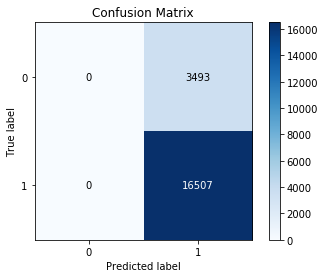

In [387]:
# Calling 'test_metric' function to predict test data and get the metrics
# n_estimators: 500
# Maximum depth: 10

ratf, ptf, ftf, retf, tf_te = test_metric(RandomForestClassifier, x_tr_tf_n, x_test_tf_n, y_tr, y_test, r_e_tf, r_m_tf)

# Calling 'mod_per' function to check model performance on test data

n_estimators: 500

Maximum depth: 10

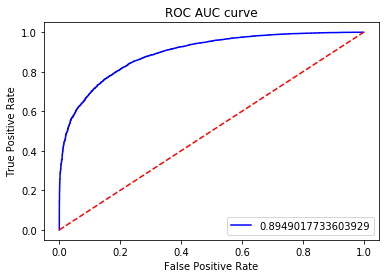

In [389]:
# Calling 'mod_per' function to check model performance on test data
# n_estimators: 500
# Maximum depth: 10

mod_per(RandomForestClassifier, x_tr_tf_n, x_test_tf_n, y_tr, y_test, r_e_tf, r_m_tf)

# Observation

Probability of model to separate positive and negative review is 89%

# Random Forest: Word2Vec

# Splitting train and test set into train and cv

In [256]:
# Splitting train and test set into train and cv

x_tr_w, x_cv_w, y_tr_w, y_cv_w = train_test_split(x_train, y_train, random_state = 0,
                                                          test_size = 0.25, shuffle = False)

In [257]:
print("Shape of x train:", x_tr_w.shape[0])
print("Shape of x cv:", x_cv_w.shape[0])
print("Shape of x test:", x_test.shape[0])
print("Shape of y train:", y_tr_w.shape[0])
print("Shape of y cv:", y_cv_w.shape[0])
print("Shape of y test:", y_test.shape[0])

Shape of x train: 60000
Shape of x cv: 20000
Shape of x test: 20000
Shape of y train: 60000
Shape of y cv: 20000
Shape of y test: 20000


# Defining a function to create Word2Vec

In [258]:
# Defining a function to create Word2Vec

def w(x_t):
    
    list_t = []
    
    for text in x_t:
        split = text.split()
        list_t.append(split)
    return list_t

# Calling function 'w' to get list of words of x_train, x_test and x_cv

In [259]:
# Calling function 'w' to get list of words of x_train, x_test and x_cv

x_tr_list = w(x_tr_w)
x_test_list = w(x_test)
x_cv_list = w(x_cv_w)

In [260]:
# Creating Word2Vec model using train data (x_train_list)

# import gensim library
import gensim

#Create an instance for the genism model
w2v_model = gensim.models.Word2Vec(x_tr_list, min_count = 5, size = 50, workers = 4)
print(w2v_model)

# Creating own corpus vocabulary
w2v_vocab = w2v_model[w2v_model.wv.vocab]
print("Shape of w2v_vocab:" + ' ' + str(w2v_vocab.shape))

# Creating list of words
w2v_word = list(w2v_model.wv.vocab)
print("Length of w2v_word:" + ' ' + str(len(w2v_word)), '\n')
print('*'*50)
print("First 10 words from the list of words w2v_word:")
w2v_word[:10]

Word2Vec(vocab=10441, size=50, alpha=0.025)
Shape of w2v_vocab: (10441, 50)
Length of w2v_word: 10441 

**************************************************
First 10 words from the list of words w2v_word:


['one',
 'movi',
 'collect',
 'fill',
 'comedi',
 'action',
 'whatev',
 'els',
 'want',
 'call']

In [261]:
# Let's check the most similar words

w2v_model.wv.most_similar('happi')

[('thrill', 0.767254114151001),
 ('glad', 0.7281593680381775),
 ('excit', 0.7044351696968079),
 ('pleas', 0.6824694871902466),
 ('abl', 0.5626934170722961),
 ('unabl', 0.5432204008102417),
 ('difficult', 0.5167108178138733),
 ('continu', 0.5043306350708008),
 ('ecstat', 0.4847886562347412),
 ('onlin', 0.47950756549835205)]

# Observation:
As we can see, .most_similar gives the similar words to the input word along with the percentage of similarity

# Defining a function for Avg Word2Vec

Convert Word2Vec to vectors.

Average Word2Vec is nothing but the average of vectors of each word of a given text/review/sentence.

In [262]:
# Defining a function for Avg Word2Vec

def sent(word_list):

    sentence = [] # avg w2v of sentence/review will be stored in the empty list

    for sen in word_list:
        zero = np.zeros(50)  # (50,) matrix which is initial to add to the first w2v of word in a sentence/review
        count_div = 0         # Increases by 1 every iteration and divides the w2v the sum of w2v sentence/review
        for word in sen:
            if word in w2v_word:
                vec = w2v_model.wv[word]  # Gets the w2v for each word in a sentence/review
                zero += vec              # Sums the w2v of each word in a sentence/review at every iteration
                count_div += 1           # Increases by 1 at every iteration
        if count_div != 0:
            zero /= count_div            # w2v of sentence/review is divided by total number of words in a sentence/review (average w2v)
        sentence.append(zero)            # Stores all the avg w2z in an empty list sentence
    
    return sentence

# Average Word2Vec- Calling 'sent' function to get Avg Word2Vec

Convert Word2Vec to vectors.

Average Word2Vec is nothing but the average of vectors of each word of a given text/review/sentence.

In [263]:
# Calling 'sent' function to get Avg Word2Vec

# Avg Word2Vec for train
x_tr_avg_w2v = sent(x_tr_list)

# Avg Word2Vec for cv
x_cv_avg_w2v = sent(x_cv_list)

# Avg Word2Vec for test
x_test_avg_w2v = sent(x_test_list)

# Normalization

In [264]:
# Normalize train data
x_tr_avg_n = normalize(x_tr_avg_w2v)
print("Shape of normalized train Avg Word2Vec:" + ' ' + str(len(x_tr_avg_n)))

# Normalize cv data
x_cv_avg_n = normalize(x_cv_avg_w2v)
print("Shape of normalized cv Avg Word2Vec:" + ' ' + str(len(x_cv_avg_n)))

# Normalize test data
x_test_avg_n = normalize(x_test_avg_w2v)
print("Shape of normalized Avg Word2Vec:" + ' ' + str(len(x_test_avg_n)))

Shape of normalized train Avg Word2Vec: 60000
Shape of normalized cv Avg Word2Vec: 20000
Shape of normalized Avg Word2Vec: 20000


# Calling 'rfi' function to find n_estimators and maximum depth

In [265]:
# Calling 'rfi' function to find n_estimators and maximum depth

r_sc_avg, r_st_avg, r_d_avg = rfi(RandomForestClassifier, x_tr_avg_n, x_cv_avg_n, y_tr_w, y_cv_w, n_est, max_dep)

******************************
Optimal values of CV
****************************** 

Optimal n_estimators of CV: 500
Optimal maximum depth of CV: 10
Corresponding AUC score of CV: 0.8890074474610458 

******************************
Optimal values of train
****************************** 

Optimal n_estimators of train: 500
Optimal maximum depth of train: 10
Corresponding AUC score of train: 0.9628579934396431


# Calling 'heat' function to visualize CV AUC score with heatmap.

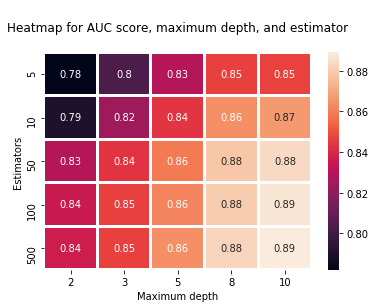

In [273]:
# Calling 'heat' function to visualize CV AUC score with heatmap.

heat(r_d_avg, 'Estimators', 'Maximum depth', 'CV AUC')

# Calling 'heat' function to visualize train AUC score with heatmap.

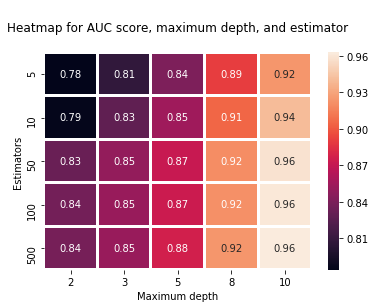

In [274]:
# Calling 'heat' function to visualize train AUC score with heatmap.

heat(r_d_avg, 'Estimators', 'Maximum depth', 'Train AUC')

# Observation:

For CV, n_estimators is 500 and maximum depth is 10 and AUC score is 89% 

For train, n_estimators is 500 and maximum depth is 10 and AUC score is 92%

Optimal n_estimators: 500

Optimal maximum depth: 10

In [275]:
r_e_avg = 500
r_m_avg = 10

# Calling 'mod_per' functio to check model performance with ROC curve CV

n_estimators: 500

Maximum depth: 10


 Model performance on CV data with estimators 500 maximum depth 10 



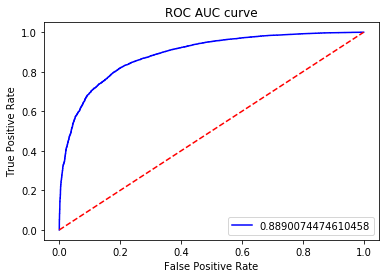

In [276]:
# Calling 'mod_per' functio to check model performance with ROC curve CV
# n_estimators: 500
# Maximum depth: 10

print("\n Model performance on CV data with estimators", r_e_avg, "maximum depth", r_m_avg, "\n")

mod_per(RandomForestClassifier, x_tr_avg_n, x_cv_avg_n, y_tr_w, y_cv_w, r_e_avg, r_m_avg)

# Observation:
    
Probability of model to separate positive and negative review is 88%

# Calling 'test_metric' function to predict test data and get metrics

n_estimators: 500

Maximum depth: 10

Metric scores of test data
************************* 

ROC AUC score:  0.885 

************************* 

Precision score:  0.858 

************************* 

F1 score:  0.92 

************************* 

Recall score:  0.99 

************************* 

Classification Report: 

              precision    recall  f1-score   support

           0       0.83      0.23      0.36      3493
           1       0.86      0.99      0.92     16507

   micro avg       0.86      0.86      0.86     20000
   macro avg       0.84      0.61      0.64     20000
weighted avg       0.85      0.86      0.82     20000
 

************************* 

Confusion matrix table: 



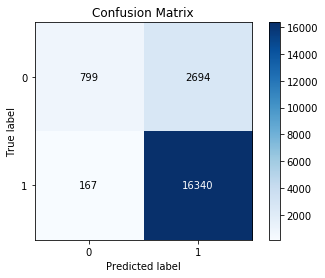

In [277]:
# Calling 'test_metric' function to predict test data and get metrics
# n_estimators: 500
# Maximum depth: 10

ra_avg, p_avg, f_avg, re_avg, ea = test_metric(RandomForestClassifier, x_tr_avg_n, x_test_avg_n, y_tr_w, y_test, r_e_avg, r_m_avg)

# Calling 'mod_per' function to check model performance on test data and get metrics

n_estimators: 500

Maximum depth: 10


 Model performance on test data with estimators 500 maximum depth 10 



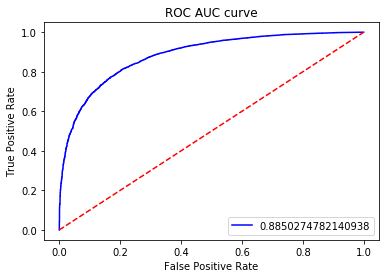

In [278]:
# Calling 'mod_per' function to check model performance on test data and get metrics
# n_estimators: 500
# Maximum depth: 10

print("\n Model performance on test data with estimators", r_e_avg, "maximum depth", r_m_avg, "\n")

mod_per(RandomForestClassifier, x_tr_avg_n, x_test_avg_n, y_tr_w, y_test, r_e_avg, r_m_avg)

# Observation:

Probability of model to separate positive and negative review is 88%

# Random Forest- TF-IDF Word2Vec

In [266]:
tf_model = TfidfVectorizer()

tf_idf_tr = tf_model.fit_transform(x_tr_w)
tf_idf_cv = tf_model.transform(x_cv_w)
tf_idf_test = tf_model.transform(x_test)

# we are converting a dictionary with word as a key, and the idf as a value

dicti = dict(zip(tf_model.get_feature_names(), list(tf_model.idf_)))

# Defining a function to get TF-IDF Word2Vec

In [267]:
# Defining a function to get TF-IDF Word2Vec

def tf_w(word_list):
    tf_sentence = []   # Empty list to store the tfidf-w2v values
    for tf_sent in word_list:
        tf_zero = np.zeros(50)     # (50,) matrix which is initial to add to the first w2v of word in a sentence/review
        tf_count = 0                # Increases by tfidf value of previous tfidf value for every iteration and divides the sum of tfidf-w2v of sentence/review
        for tf_word in tf_sent:
            if tf_word in w2v_word:
                tf_vec = w2v_model.wv[tf_word]  # Get tfidf_w2v for each word in a sentence/review       
                if tf_word in dicti:
                    # tf_w2v = tf_idf_matrix[row, tf_feat.index(tf_word)]
                    tf_w2v = dicti[tf_word] * (tf_sent.count(tf_word))/len(tf_sent) 
                    tf_zero += (tf_vec * tf_w2v)    # Increase by tfidf-w2v value for every iteration
                    tf_count += tf_w2v              # Increase by ifidf value for every iteration
        if tf_count != 0:
            tf_zero /= tf_count                     # tfidf-w2v of sentence/review is divided by total number of tfidf of words in a sentence/review (tfidf-w2v)
        tf_sentence.append(tf_zero)                # Stores all the avg w2z in an empty list sentence
    
    return tf_sentence

# Calling 'tf_w' function to get TF-IDF Word2Vec

In [317]:
# Calling 'tf_w' function to get TF-IDF Word2Vec

# Avg Word2Vec for train
x_tr_tf_w2v = tf_w(x_tr_list)

# Avg Word2Vec for cv
x_cv_tf_w2v = tf_w(x_cv_list)

# Avg Word2Vec for test
x_test_tf_w2v = tf_w(x_test_list)

# Normalization

In [318]:
# Normalize train data
x_tr_tf_n = normalize(x_tr_tf_w2v)
print("Shape of normalized train TFIDF Word2Vec:" + ' ' + str(len(x_tr_tf_n)))

# Normalize cv data
x_cv_tf_n = normalize(x_cv_tf_w2v)
print("Shape of normalized cv TFIDF Word2Vec:" + ' ' + str(len(x_cv_tf_n)))

# Normalize test data
x_test_tf_n = normalize(x_test_tf_w2v)
print("Shape of normalized TFIDF Word2Vec:" + ' ' + str(len(x_test_tf_n)))

Shape of normalized train TFIDF Word2Vec: 60000
Shape of normalized cv TFIDF Word2Vec: 20000
Shape of normalized TFIDF Word2Vec: 20000


# Calling 'rfi' function to find n_estimators and maximum depth.

In [270]:
# Calling 'rfi' function to find n_estimators and maximum depth.

r_sc_tw, r_st_tw, r_d_tw = rfi(RandomForestClassifier, x_tr_tf_n, x_cv_tf_n, y_tr_w, y_cv_w, n_est, max_dep)

******************************
Optimal values of CV
****************************** 

Optimal n_estimators of CV: 500
Optimal maximum depth of CV: 10
Corresponding AUC score of CV: 0.8564512214098161 

******************************
Optimal values of train
****************************** 

Optimal n_estimators of train: 500
Optimal maximum depth of train: 10
Corresponding AUC score of train: 0.9502463595351265


# Calling 'heat' function to visualize CV AUC score with heatmap.

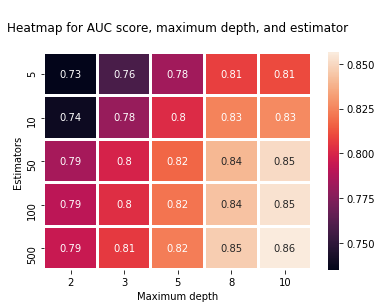

In [279]:
# Calling 'heat' function to visualize CV AUC score with heatmap.

heat(r_d_tw, 'Estimators', 'Maximum depth', 'CV AUC')

# Calling 'heat' function to visualize train AUC score with heatmap.

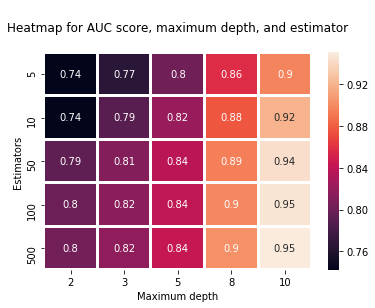

In [280]:
# Calling 'heat' function to visualize train AUC score with heatmap.

heat(r_d_tw, 'Estimators', 'Maximum depth', 'Train AUC')

# Observation:

For CV, n_estimators is 500 and maximum depth is 10 and AUC score is 85% 

For train, n_estimators is 500 and maximum depth is 10 and AUC score is 95%

Optimal n_estimators: 500

Optimal maximum depth: 10

In [281]:
r_e_tw = 500
r_m_tw = 10

# Calling 'mod_per' function to check model performance with ROC curve on CV

n_estimators: 500

Maximum depth: 10


 Model performance on train and cv with estimators 500 maximum depth 10 



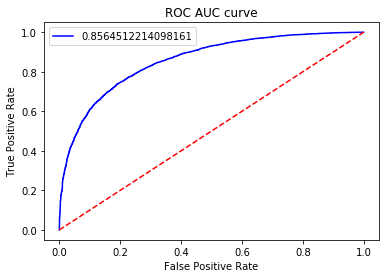

In [282]:
# Calling 'mod_per' function to check model performance with ROC curve on CV
# n_estimators: 500
# Maximum depth: 10

print("\n Model performance on train and cv with estimators", r_e_tw, "maximum depth", r_m_tw, "\n")

mod_per(RandomForestClassifier, x_tr_tf_n, x_cv_tf_n, y_tr_w, y_cv_w, r_e_tw, r_m_tw)

# Observation:
    
Probability of model to separate positive and negative review is 85%

# Calling 'test_metric' to predict test data and get metrics

n_estimators: 500

Maximum depth: 10

Metric scores of test data
************************* 

ROC AUC score:  0.851 

************************* 

Precision score:  0.848 

************************* 

F1 score:  0.915 

************************* 

Recall score:  0.993 

************************* 

Classification Report: 

              precision    recall  f1-score   support

           0       0.83      0.16      0.27      3493
           1       0.85      0.99      0.92     16507

   micro avg       0.85      0.85      0.85     20000
   macro avg       0.84      0.58      0.59     20000
weighted avg       0.85      0.85      0.80     20000
 

************************* 

Confusion matrix table: 



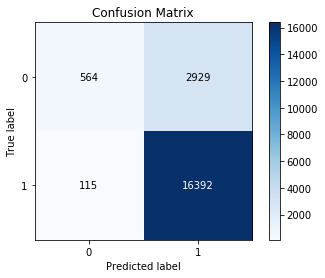

In [283]:
# Calling 'test_metric' to predict test data and get metrics
# n_estimators: 500
# Maximum depth: 10

ra_tw, p_tw, f_tw, re_tw, tq = test_metric(RandomForestClassifier, x_tr_tf_n, x_test_tf_n, y_tr_w, y_test, r_e_tw, r_m_tw)

# Calling 'mod_per' function to check model performance on test data

n_estimators: 500

Maximum depth: 10


 Model performance on train and cv with n_estimators 500 and maximum depth 10 



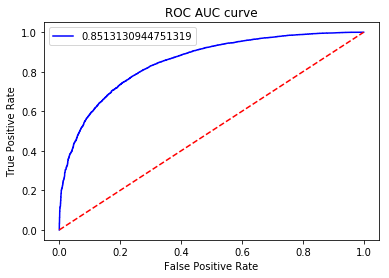

In [284]:
# Calling 'mod_per' function to check model performance on test data
# n_estimators: 500
# Maximum depth: 10

print("\n Model performance on train and cv with n_estimators", r_e_tw, "and maximum depth", r_m_tw, "\n")

mod_per(RandomForestClassifier, x_tr_tf_n, x_test_tf_n, y_tr_w, y_test, r_e_tw, r_m_tw)

# Observation:
     
Probability of model to separate positive and negative review is 85%.

# Top 20 important features for BoW and TFIDF

# Defining a function to get top 20 important features and visualize graphically

For graphical representation and word cloud, referred https://www.datacamp.com/community/tutorials/wordcloud-python

In [285]:
# Defining a function to get top 20 important features and visualize graphically

# Importing libraries
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

def top_feat(vectorizer, important, n):
    
    # Getting top important features
    
    feat = vectorizer.get_feature_names()             # Gets all the feature names from vecotrizer (BOW, TF-IDF)
    imp = important.feature_importances_               # Gets co-efficients of feature names (BOW, TF-IDF)
    fe_imp = sorted(zip(imp, feat), reverse = True)                   # Sorts and zips feature names and co-efficients correspondingly
    top_feat = fe_imp[:n]       # Zips all n number of feature names and co-efficients correspondingly
    #feat_num =  sorted(imp, reverse = True)
    
    print("\nTop 20 important features")
    print('-'*30, '\n')
    for (fea_1, imp_1) in top_feat:              # loop to print n number of features 
        print("%.4f\t%-15s" % (fea_1, imp_1))

    #________________________________________________________________________________#
    
    # Creating list of weights and features
    
    weights = []                                  # Stores weights of features
    names = []                                    # Stores features 
    
    for i in range(n):
        
        wt = top_feat[i][0]                        # Picks out the weights
        na = top_feat[i][1]                        # Picks out the features
        
        weights.append(wt)                         # Appends weights 
        names.append(na)                           # Appends features
        
    #___________________________________________________________________________________#
    
    # Graphical representation of important features
    
    print('\n\n\t\t\t Graphical representation of top', n, 'important features\n')
    plt.figure(figsize = (12,6))
    plt.bar(range(n), weights)
    plt.xlabel("Top important features")
    plt.title("Top 20 important features", fontsize = 15)
    plt.xticks(range(20), labels = names, rotation = 70, fontsize = 15)
    
    #___________________________________________________________________________________#
    
    # Word Cloud
    
    #print('\n\n\n\t\t\t Word Cloud top', n, 'important features\n')
    lis = ' '.join(names)
    wc = WordCloud(background_color = 'white', max_words = n)
    wcg = wc.generate(lis)
    
    plt.figure(figsize = (10,8))
    plt.imshow(wcg, interpolation = 'bilinear')

# BoW- Calling 'top_feat' function to get top 20 important features, visualize graphically and get word cloud.


Top 20 important features
------------------------------ 

0.0099	worst          
0.0082	bad            
0.0081	great          
0.0070	wast money     
0.0066	best           
0.0058	horribl        
0.0053	threw          
0.0051	wast           
0.0047	tasteless      
0.0045	disappoint     
0.0044	throw away     
0.0044	descript       
0.0044	aw             
0.0043	guess          
0.0042	wrong          
0.0041	bewar          
0.0040	rip            
0.0039	perfect        
0.0036	read           
0.0036	contact        


			 Graphical representation of top 20 important features



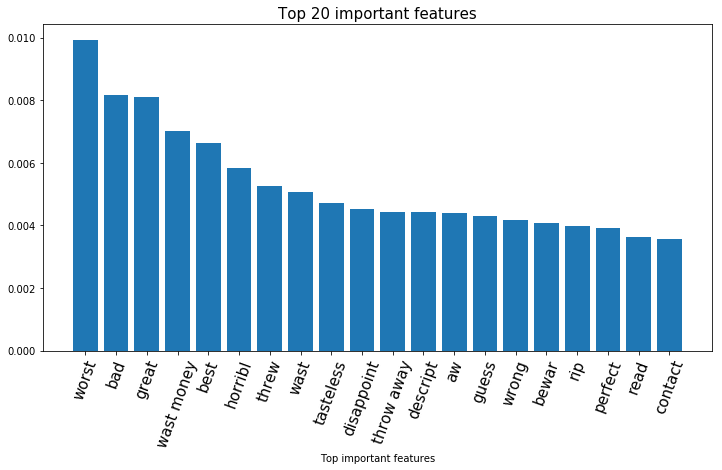

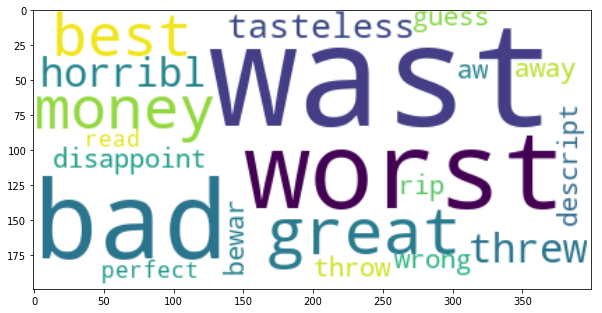

In [286]:
# BoW- Calling 'top_feat' function to get top 20 important features, visualize graphically and get word cloud.

top_feat(cv, bow_te, 20)

# TFIDF- Calling 'top_feat' function to get top 20 important features, visualize graphically and get word cloud.


Top 20 important features
------------------------------ 

0.0223	great          
0.0216	disappoint     
0.0192	worst          
0.0181	money          
0.0160	refund         
0.0154	bad            
0.0150	return         
0.0137	aw             
0.0134	wast           
0.0121	love           
0.0120	threw          
0.0119	best           
0.0115	thought        
0.0114	terribl        
0.0107	would          
0.0105	stale          
0.0101	disgust        
0.0100	gross          
0.0098	unfortun       
0.0096	horribl        


			 Graphical representation of top 20 important features



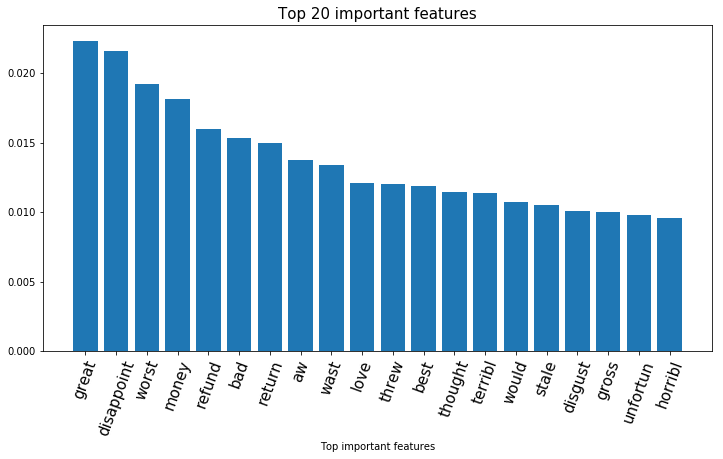

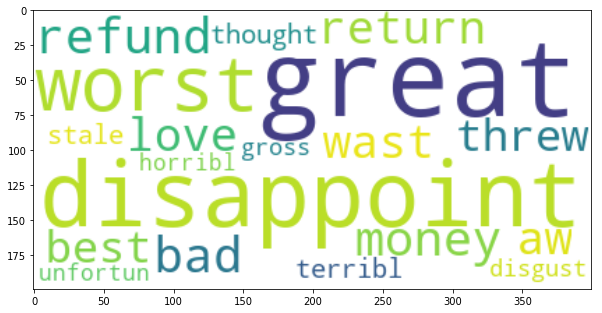

In [287]:
# TFIDF- Calling 'top_feat' function to get top 20 important features, visualize graphically and get word cloud.

top_feat(tf, tf_te, 20)

# GBDT- Bag of Words

# Calling 'rfi' function to find the optimal n_estimators and maximum depth.

In [400]:
# Calling 'rfi' function to find the optimal n_estimators and maximum depth.

g_sc_b, g_st_b, g_d_b = rfi(XGBClassifier, x_tr_n, x_cv_n, y_tr, y_cv, n_est, max_dep)

******************************
Optimal values of CV
****************************** 

Optimal n_estimators of CV: 500
Optimal maximum depth of CV: 10
Corresponding AUC score of CV: 0.9440917012319198 

******************************
Optimal values of train
****************************** 

Optimal n_estimators of train: 500
Optimal maximum depth of train: 10
Corresponding AUC score of train: 0.9965153240711628


# Calling 'heat' function to visualize CV AUC with heatmap

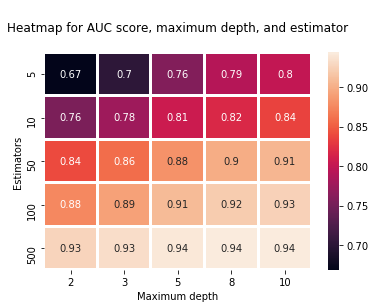

In [401]:
# Calling 'heat' function to visualize CV AUC score with heatmap.

heat(g_d_b, 'Estimators', 'Maximum depth', 'CV AUC')

# Calling 'heat' function to visualize Train AUC score with heatmap.

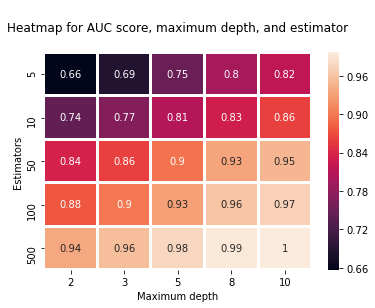

In [402]:
# Calling 'heat' function to visualize CV AUC score with heatmap.

heat(g_d_b, 'Estimators', 'Maximum depth', 'Train AUC')

# Observation:

For CV, n_estimators is 500 and maximum depth is 10 and AUC score is 94% 

For train, n_estimators is 500 and maximum depth is 10 and AUC score is 99%

Optimal n_estimators: 500

Optimal maximum depth: 10

In [403]:
g_e_b = 500
g_m_b = 10

# Calling 'mod_per' function to check the performance model with ROC curve on CV

n_estimators: 500

maximum depth: 10

 
 Model performance with estimators 500 and maximum depth 10 



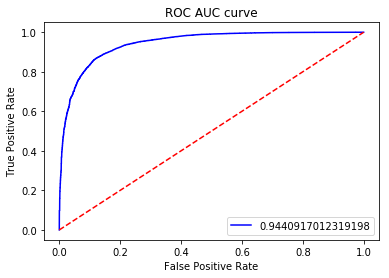

In [405]:
# Calling 'mod_per' function to check the performance model with ROC curve on CV.
# n_estimators = 500
# Maximum depth = 10

print(" \n Model performance with estimators", g_e_b,"and maximum depth", g_m_b,'\n')

mod_per(XGBClassifier, x_tr_n, x_cv_n, y_tr, y_cv, g_e_b, g_m_b)

# Observation:
    
We can see that the model probability to separate positive and negative review is 94%

# Calling 'test_metric' function to predict test data and get metrics

n_estimators: 500

Maximum depth: 10

Metric scores of test data
************************* 

ROC AUC score:  0.941 

************************* 

Precision score:  0.913 

************************* 

F1 score:  0.946 

************************* 

Recall score:  0.981 

************************* 

Classification Report: 

              precision    recall  f1-score   support

           0       0.86      0.56      0.68      3493
           1       0.91      0.98      0.95     16507

   micro avg       0.91      0.91      0.91     20000
   macro avg       0.89      0.77      0.81     20000
weighted avg       0.90      0.91      0.90     20000
 

************************* 

Confusion matrix table: 



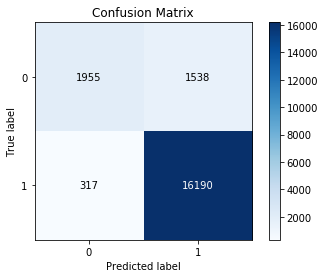

In [406]:
# Calling 'test_metric' function to predict test data and get metrics
# n_estimators: 500
# Maximum depth: 10

g_rab, g_pb, g_fb, g_reb, g_bow_te = test_metric(XGBClassifier, x_tr_n, x_test_n, y_tr, y_test, g_e_b, g_m_b)

# Calling 'mod_per' to check model performance with ROC AUC curve on test data

n_estimators: 500

Maximum depth: 10

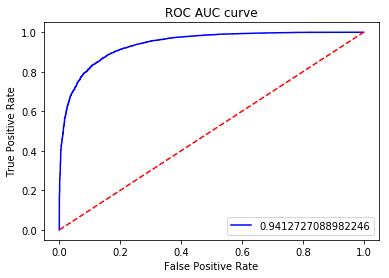

In [407]:
# Calling 'mod_per' to check model performance with ROC AUC curve on test data
# n_estimators: 500
# Maximum depth: 10

mod_per(XGBClassifier, x_tr_n, x_test_n, y_tr, y_test, g_e_b, g_m_b)

# Observation

Model probabillity of separating positive and negative review is 94%

# GBDT- TF-IDF: Term Frequency Inverse Document Frequency

# Calling 'rfi' function to find n_estimators and maximum depth.

In [390]:
# Calling 'rfi' function to find n_estimators and maximum depth.

g_sc_tf, g_st_tf, g_d_tf = rfi(XGBClassifier, x_tr_tf_n, x_cv_tf_n, y_tr, y_cv, n_est, max_dep)

******************************
Optimal values of CV
****************************** 

Optimal n_estimators of CV: 500
Optimal maximum depth of CV: 10
Corresponding AUC score of CV: 0.9412368573927945 

******************************
Optimal values of train
****************************** 

Optimal n_estimators of train: 500
Optimal maximum depth of train: 10
Corresponding AUC score of train: 0.996977116195561


# Calling 'heat' function to visualize CV AUC with heatmap

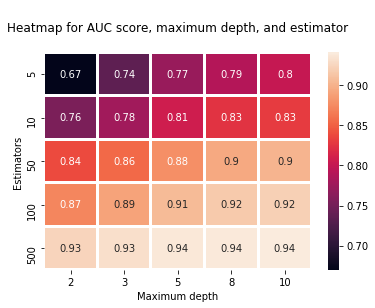

In [394]:
# Calling 'heat' function to visualize CV AUC with heatmap

heat(g_d_tf, 'Estimators', 'Maximum depth', 'CV AUC')

# Calling 'heat' function to visualize Train AUC with heatmap

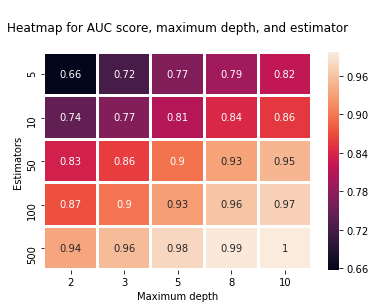

In [395]:
# Calling 'heat' function to visualize Train AUC with heatmap

heat(g_d_tf, 'Estimators', 'Maximum depth', 'Train AUC')

# Observation:

For CV, n_estimators is 500 and maximum depth is 10 and AUC score is 94% 

For train, n_estimators is 500 and maximum depth is 10 and AUC score is 100%

Optimal n_estimators: 500

Optimal maximum depth: 10

In [396]:
g_e_tf = 500
g_m_tf = 10

# Calling 'mod_per' function to check the model performance with ROC AUC score on CV data

n_estimators: 500

Maximum depth: 10

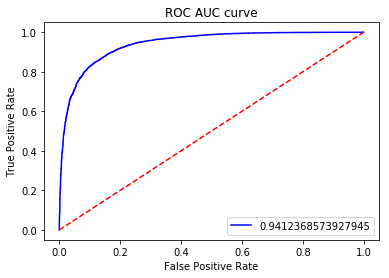

In [397]:
# Calling 'mod_per' function to check the model performance with ROC AUC score on CV data
# n_estimators: 500
# Maximum depth: 10

mod_per(XGBClassifier, x_tr_tf_n, x_cv_tf_n, y_tr, y_cv, g_e_tf, g_m_tf)

# Observation:

Probability of model to separate positive and negative review is 94%

# Calling 'test_metric' function to predict test data and get the metrics

n_estimators: 500

Maximum depth: 10

Metric scores of test data
************************* 

ROC AUC score:  0.938 

************************* 

Precision score:  0.911 

************************* 

F1 score:  0.944 

************************* 

Recall score:  0.98 

************************* 

Classification Report: 

              precision    recall  f1-score   support

           0       0.86      0.55      0.67      3493
           1       0.91      0.98      0.94     16507

   micro avg       0.90      0.90      0.90     20000
   macro avg       0.88      0.76      0.81     20000
weighted avg       0.90      0.90      0.90     20000
 

************************* 

Confusion matrix table: 



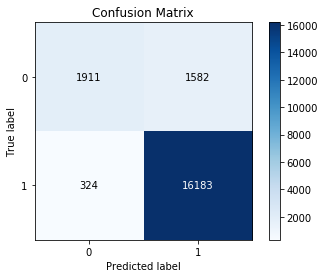

In [398]:
# Calling 'test_metric' function to predict test data and get the metrics
# n_estimators: 500
# Maximum depth: 10

g_ratf, g_ptf, g_ftf, g_retf, g_tf_te = test_metric(XGBClassifier, x_tr_tf_n, x_test_tf_n, y_tr, y_test, g_e_tf, g_m_tf)

# Calling 'mod_per' function to check model performance on test data

n_estimators: 500

Maximum depth: 10

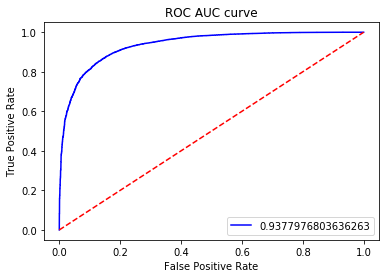

In [399]:
# Calling 'mod_per' function to check model performance on test data
# n_estimators: 500
# Maximum depth: 10

mod_per(XGBClassifier, x_tr_tf_n, x_test_tf_n, y_tr, y_test, g_e_tf, g_m_tf)

# Observation

Probability of model to separate positive and negative review is 93%

# GBDT- Average Word2Vec

In [295]:
print("Shape of x train:", x_tr_w.shape[0])
print("Shape of x cv:", x_cv_w.shape[0])
print("Shape of x test:", x_test.shape[0])
print("Shape of y train:", y_tr_w.shape[0])
print("Shape of y cv:", y_cv_w.shape[0])
print("Shape of y test:", y_test.shape[0])

Shape of x train: 60000
Shape of x cv: 20000
Shape of x test: 20000
Shape of y train: 60000
Shape of y cv: 20000
Shape of y test: 20000


# Calling 'rfi' function to find n_estimators and maximum depth

In [296]:
# Calling 'rfi' function to find n_estimators and maximum depth

g_sc_avg, g_st_avg, g_d_avg = rfi(XGBClassifier, x_tr_avg_n, x_cv_avg_n, y_tr_w, y_cv_w, n_est, max_dep)

******************************
Optimal values of CV
****************************** 

Optimal n_estimators of CV: 500
Optimal maximum depth of CV: 10
Corresponding AUC score of CV: 0.9101746367597046 

******************************
Optimal values of train
****************************** 

Optimal n_estimators of train: 500
Optimal maximum depth of train: 10
Corresponding AUC score of train: 0.9999999999999999


# Calling 'heat' function to visualize CV AUC score with heatmap.

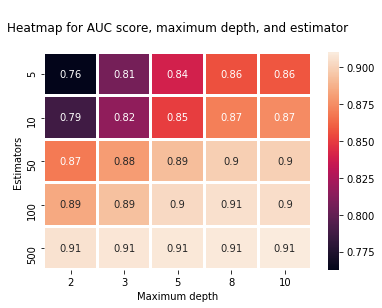

In [408]:
# Calling 'heat' function to visualize CV AUC score with heatmap.

heat(g_d_avg, 'Estimators', 'Maximum depth', 'CV AUC')

# Calling 'heat' function to visualize Train AUC score with heatmap.

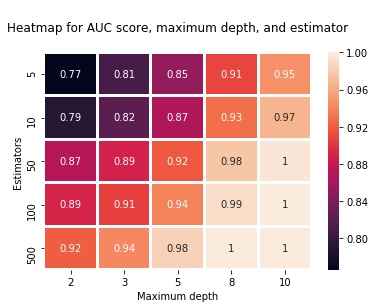

In [410]:
# Calling 'heat' function to visualize Train AUC score with heatmap.

heat(g_d_avg, 'Estimators', 'Maximum depth', 'Train AUC')

# Observation:

For CV, n_estimators is 500 and maximum depth is 10 and AUC score is 91% 

For train, n_estimators is 500 and maximum depth is 10 and AUC score is 99%

Optimal n_estimators: 500

Optimal maximum depth: 10

In [307]:
g_e_avg = 500
g_m_avg = 10

# Calling 'mod_per' functio to check model performance with ROC curve CV

n_estimators: 500

Maximum depth: 10


 Model performance on CV data with estimators 500 maximum depth 10 



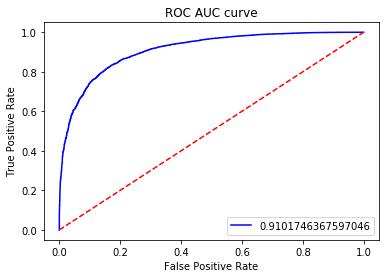

In [308]:
# Calling 'mod_per' functio to check model performance with ROC curve CV
# n_estimators: 500
# Maximum depth: 10

print("\n Model performance on CV data with estimators", g_e_avg, "maximum depth", g_m_avg, "\n")

mod_per(XGBClassifier, x_tr_avg_n, x_cv_avg_n, y_tr_w, y_cv_w, g_e_avg, g_m_avg)

# Observation:
    
Probability of model to separate positive and negative review is 91%

# Calling 'test_metric' function to predict test data and get metrics

n_estimators: 500

Maximum depth: 10

Metric scores of test data
************************* 

ROC AUC score:  0.906 

************************* 

Precision score:  0.894 

************************* 

F1 score:  0.931 

************************* 

Recall score:  0.97 

************************* 

Classification Report: 

              precision    recall  f1-score   support

           0       0.77      0.46      0.57      3493
           1       0.89      0.97      0.93     16507

   micro avg       0.88      0.88      0.88     20000
   macro avg       0.83      0.71      0.75     20000
weighted avg       0.87      0.88      0.87     20000
 

************************* 

Confusion matrix table: 



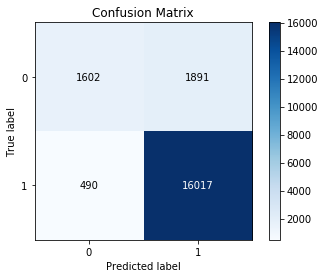

In [309]:
# Calling 'test_metric' function to predict test data and get metrics
# n_estimators: 500
# Maximum depth: 10

g_ra_avg, g_p_avg, g_f_avg, g_re_avg, g_ea = test_metric(XGBClassifier, x_tr_avg_n, x_test_avg_n, y_tr_w, y_test, g_e_avg, g_m_avg)

# Calling 'mod_per' function to check model performance on test data and get metrics

n_estimators: 500

Maximum depth: 10


 Model performance on test data with estimators 500 maximum depth 10 



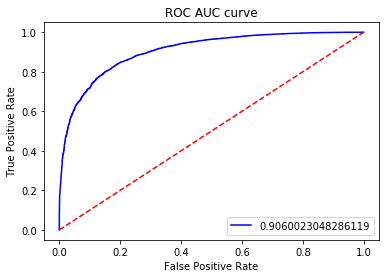

In [310]:
# Calling 'mod_per' function to check model performance on test data and get metrics
# n_estimators: 500
# Maximum depth: 10

print("\n Model performance on test data with estimators", g_e_avg, "maximum depth", g_m_avg, "\n")

mod_per(XGBClassifier, x_tr_avg_n, x_test_avg_n, y_tr_w, y_test, g_e_avg, g_m_avg)

# Observation:

Probability of model to separate positive and negative review is 90%

# GBDT- TF-IDF Word2Vec

# Calling 'rfi' function to find n_estimators and maximum depth.

In [297]:
# Calling 'rfi' function to find n_estimators and maximum depth.

g_sc_tw, g_st_tw, g_d_tw = rfi(XGBClassifier, x_tr_tf_n, x_cv_tf_n, y_tr_w, y_cv_w, n_est, max_dep)

******************************
Optimal values of CV
****************************** 

Optimal n_estimators of CV: 500
Optimal maximum depth of CV: 10
Corresponding AUC score of CV: 0.8849404260684522 

******************************
Optimal values of train
****************************** 

Optimal n_estimators of train: 500
Optimal maximum depth of train: 10
Corresponding AUC score of train: 1.0


# Calling 'heat' function to visualize CV AUC score with heatmap.

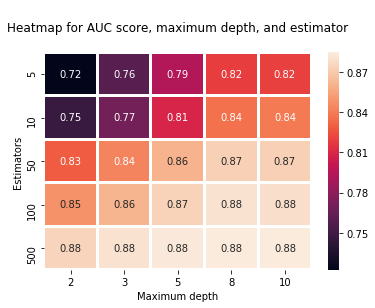

In [411]:
# Calling 'heat' function to visualize CV AUC score with heatmap.

heat(g_d_tw, 'Estimators', 'Maximum depth', 'CV AUC')

# Calling 'heat' function to visualize Train AUC score with heatmap.

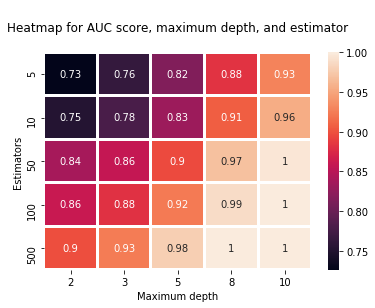

In [412]:
# Calling 'heat' function to visualize Train AUC score with heatmap.

heat(g_d_tw, 'Estimators', 'Maximum depth', 'Train AUC')

# Observation:

For CV, n_estimators is 500 and maximum depth is 10 and AUC score is 88% 

For train, n_estimators is 500 and maximum depth is 10 and AUC score is 100%

Optimal n_estimators: 500

Optimal maximum depth: 10

In [314]:
g_e_tw = 500
g_m_tw = 10

# Calling 'mod_per' function to check model performance with ROC curve on CV

n_estimators: 500

Maximum depth: 10


 Model performance on train and cv with estimators 500 maximum depth 10 



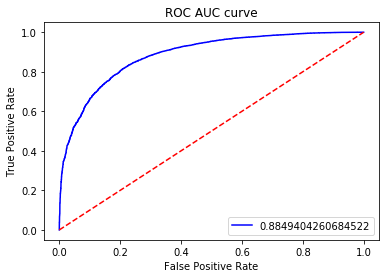

In [315]:
# Calling 'mod_per' function to check model performance with ROC curve on CV
# n_estimators: 500
# Maximum depth: 10

print("\n Model performance on train and cv with estimators", g_e_tw, "maximum depth", g_m_tw, "\n")

mod_per(XGBClassifier, x_tr_tf_n, x_cv_tf_n, y_tr_w, y_cv_w, g_e_tw, g_m_tw)

# Observation:
    
Probability of model to separate positive and negative review is 88%

# Calling 'test_metric' to predict test data and get metrics

n_estimators: 500

Maximum depth: 10

Metric scores of test data
************************* 

ROC AUC score:  0.879 

************************* 

Precision score:  0.881 

************************* 

F1 score:  0.925 

************************* 

Recall score:  0.972 

************************* 

Classification Report: 

              precision    recall  f1-score   support

           0       0.74      0.38      0.50      3493
           1       0.88      0.97      0.92     16507

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.81      0.68      0.71     20000
weighted avg       0.86      0.87      0.85     20000
 

************************* 

Confusion matrix table: 



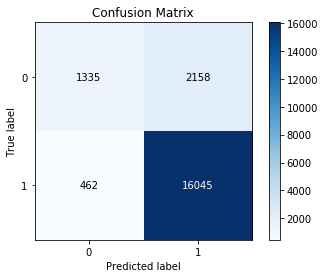

In [319]:
# Calling 'test_metric' to predict test data and get metrics
# n_estimators: 500
# Maximum depth: 10

g_ra_tw, g_p_tw, g_f_tw, g_re_tw, g_tq = test_metric(XGBClassifier, x_tr_tf_n, x_test_tf_n, y_tr_w, y_test, g_e_tw, g_m_tw)

# Calling 'mod_per' function to check model performance on test data

n_estimators: 500

Maximum depth: 10


 Model performance on train and cv with n_estimators 500 and maximum depth 10 



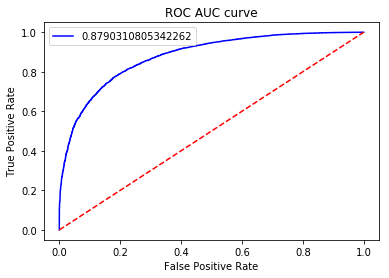

In [320]:
# Calling 'mod_per' function to check model performance on test data
# n_estimators: 500
# Maximum depth: 10

print("\n Model performance on train and cv with n_estimators", g_e_tw, "and maximum depth", g_m_tw, "\n")

mod_per(XGBClassifier, x_tr_tf_n, x_test_tf_n, y_tr_w, y_test, g_e_tw, g_m_tw)

# Observation:
     
Probability of model to separate positive and negative review is 87%.

# GBDT: BoW- Calling 'top_feat' function to get top 20 important features, visualize graphically and get word cloud.


Top 20 important features
------------------------------ 

0.0332	tast           
0.0309	like           
0.0227	product        
0.0226	would          
0.0199	good           
0.0191	tri            
0.0186	one            
0.0184	flavor         
0.0140	get            
0.0138	love           
0.0134	use            
0.0113	buy            
0.0105	great          
0.0095	amazon         
0.0082	price          
0.0078	make           
0.0074	much           
0.0073	order          
0.0071	realli         
0.0070	food           


			 Graphical representation of top 20 important features



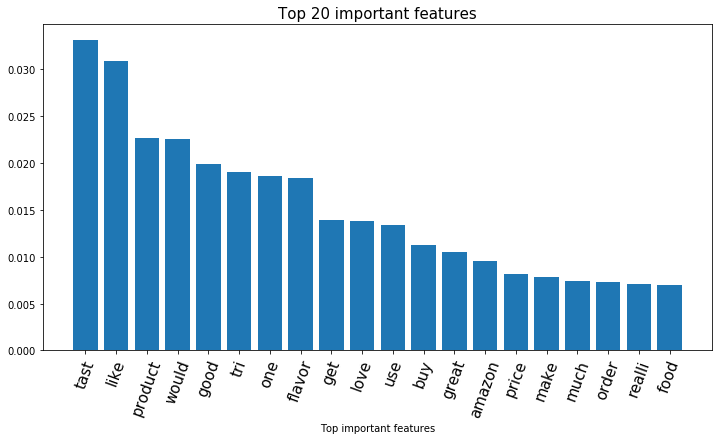

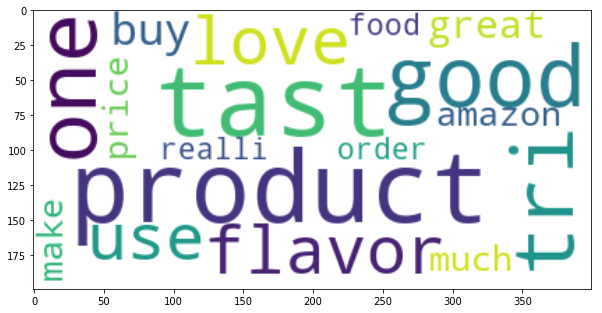

In [330]:
# BoW- Calling 'top_feat' function to get top 20 important features, visualize graphically and get word cloud.

top_feat(cv, g_bow_te, 20)

# GBDT: TFIDF- Calling 'top_feat' function to get top 20 important features, visualize graphically and get word cloud.


Top 20 important features
------------------------------ 

0.0688	like           
0.0534	tast           
0.0448	great          
0.0430	good           
0.0396	real           
0.0327	love           
0.0327	flavor         
0.0258	money          
0.0241	product        
0.0224	someth         
0.0224	bag            
0.0189	use            
0.0189	look           
0.0172	receiv         
0.0172	almost         
0.0155	recommend      
0.0155	get            
0.0138	nice           
0.0138	expect         
0.0120	would          


			 Graphical representation of top 20 important features



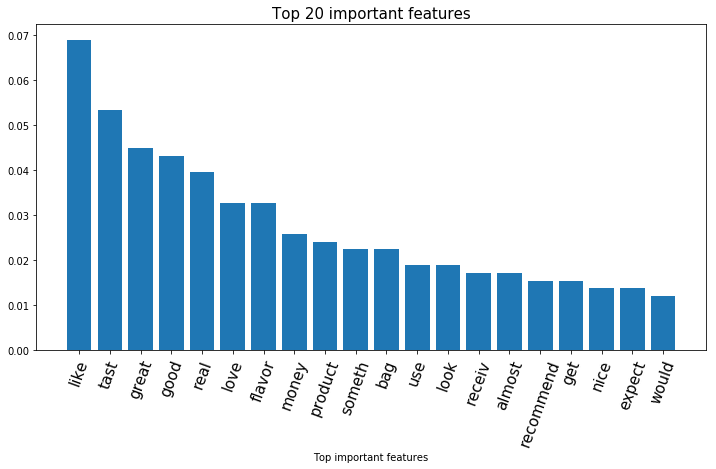

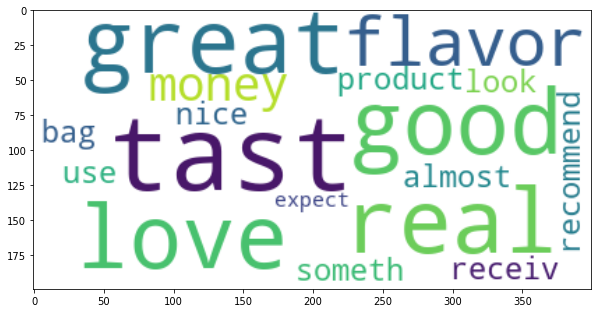

In [200]:
# TFIDF- Calling 'top_feat' function to get top 20 important features, visualize graphically and get word cloud.

top_feat(tf, g_tf_te, 20)

# Pretty Table

In [413]:
from prettytable import PrettyTable

a = PrettyTable()

a.field_names = ['S.No', 'Vectorizer', 'Estimator', 'Maximum depth', 'AUC score', 'Precision', 'F1-score', 'Recall']

a.add_row([1, 'Bag of Words', r_e_b, r_m_b, rab, pb, fb, reb])
a.add_row([2, 'TF-IDF', r_e_tf, r_m_tf, ratf, ptf, ftf, retf])
a.add_row([3, 'Avg Word2Vec', r_e_avg, r_m_avg, ra_avg, p_avg, f_avg, re_avg])
a.add_row([4, 'TF-IDF Word2Vec', r_e_tw, r_m_tw, ra_tw, p_tw, f_tw, re_tw])

print('\n')
print(a.get_string(title = 'Table for Random Forest'))

from prettytable import PrettyTable

b = PrettyTable()

b.field_names = ['S.No', 'Vectorizer', 'Estimator', 'Maximum depth', 'AUC score', 'Precision', 'F1-score', 'Recall']

b.add_row([1, 'Bag of Words', g_e_b, g_m_b, g_rab, g_pb, g_fb, g_reb])
b.add_row([2, 'TF-IDF', g_e_tf, g_m_tf, g_ratf, g_ptf, g_ftf, g_retf])
b.add_row([3, 'Avg Word2Vec', g_e_avg, g_m_avg, g_ra_avg, g_p_avg, g_f_avg, g_re_avg])
b.add_row([4, 'TF-IDF Word2Vec', g_e_tw, g_m_tw, g_ra_tw, g_p_tw, g_f_tw, g_re_tw])


print('\n'*2)
print(b.get_string(title = 'Table for (GBDT) Gradient Boost Decision Tree'))



+------------------------------------------------------------------------------------------------+
|                                    Table for Random Forest                                     |
+------+-----------------+-----------+---------------+-----------+-----------+----------+--------+
| S.No |    Vectorizer   | Estimator | Maximum depth | AUC score | Precision | F1-score | Recall |
+------+-----------------+-----------+---------------+-----------+-----------+----------+--------+
|  1   |   Bag of Words  |    500    |       8       |   0.895   |   0.825   |  0.904   |  1.0   |
|  2   |      TF-IDF     |    500    |       10      |   0.895   |   0.825   |  0.904   |  1.0   |
|  3   |   Avg Word2Vec  |    500    |       10      |   0.885   |   0.858   |   0.92   |  0.99  |
|  4   | TF-IDF Word2Vec |    500    |       10      |   0.851   |   0.848   |  0.915   | 0.993  |
+------+-----------------+-----------+---------------+-----------+-----------+----------+--------+



+----

# Conclusion

# Random Forest

AUC score for BoW and TFIDF is more when compare to other vectorizer. Highest score being ~89% with estimator 500 and maximum depth 8 & 10.

Lowest score being 85% for TFIDF Word2Vec.

# GBDT- Gradient Boost Decision Tree

AUC score for BoW is more when compare to other vectorizer. Highest score being ~94% with estimator 500 and maximum depth 10.

Lowest score being 87% for TFIDF Word2Vec.

# Overall Conclusion:
    
We can see, GBDT gave better AUC score when compared Random Forest algorithm for all vectorizer. With GBDT, there is at least 2% increase in AUC score when compared to Random Forest for all vectorizers.

GBDT can be considered as best algorithm over Random Forest algorithm.